# Projet Greedy Algorithm, NAVARRE Victor CACHERA Alexandre

In [283]:
#Activation du multithreading
import sys
print(sys.prefix)

import os


os.environ["OMP_NUM_THREADS"] = "11"  # pour OpenMP
os.environ["OPENBLAS_NUM_THREADS"] = "11"
os.environ["MKL_NUM_THREADS"] = "11"

c:\Users\NAVARRE Victor\anaconda3\envs\apprentissage_profond


## Modules

In [284]:
#Importation des librairies

import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.optimize import minimize
import time

## Algorithmes Gloutons

### Fonctions de base 

In [285]:
def proj(f, Vn):

    V = np.column_stack(Vn) 
    coeffs, _, _, _ = np.linalg.lstsq(V, f, rcond=None)
    proj = V @ coeffs
    return proj

def dist(f,Vn):
    return(np.linalg.norm(f-proj(f,Vn)))

### Algorithme Strong Greedy

In [286]:
def stronggreedy(F, n):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)           
    Sigma.append(np.linalg.norm(f0))

    for i in range(n):
        id_f = np.argmax([dist(f, Vn) for f in F]) 
        f = F[id_f]
        Sigma.append(dist(f,Vn))
        Vn.append(f)            
    
    return Vn, Sigma

### Algorithme Weak Greedy

On commence par décrire l'Algorithme Greedy faible pour les n-withd, on réalise une implémentation récursive

In [287]:
def weakgreedy(F, gamma, n, sample_size):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)          
    Sigma.append(np.linalg.norm(f0))
    
    for i in range(n):
        
        # On cherche une approximation de la distance maximale
        sample_indices = np.random.choice(len(F), size=sample_size, replace=False)
        sample_distances = []
        
        for idx in sample_indices:
            f = F[idx]
            sample_distances.append(dist(f,Vn))

        current_max = np.max(sample_distances)

        for f in F:   #ici premier choisi, sinon les tirer tous et choisir aléatoirement parmi les bons candidats
            if dist(f,Vn) >= gamma*current_max:
                Sigma.append(dist(f,Vn))               #Je suis quasi convaincu  qu'il faut pas mettre max ça casse tout le concept
                Vn.append(f)  
                break
    return Vn, Sigma

### Algorithme Weak Weak Greedy

On propose une autre version de l'algorithme glouton faible. Pour réalise l'hypothèse que la distance maximale est proche de celle précédement calculé par l'algorithme faible. Cette méthode ne fonctionne que pour des gamma strictement inférieur à 1. Nous n'avons pas d'assurance quand à l'existence d'un prochain terme, encore moins la convergence. Cette algorithme faible-faible est néanmoins très interessant d'un point de vue ressources utilisée. On peut imaginer une construction randomisée avec plusieurs initialisation pour ne conserver que l'espace d'approximation soit le plus performant sois du degré le plus important.

In [288]:
def weakweakgreedy(F, gamma, n):
    
    Vn=[]
    Sigma = []
    id_f0 = np.argmax([np.linalg.norm(f) for f in F]) 
    f0 = F[id_f0]
    Vn.append(f0)          
    Sigma.append(np.linalg.norm(f0))
    current_max=np.linalg.norm(f0)
    for i in range(n):
        echec=True
        for f in F:   #ici premier choisi, sinon les tirer tous et choisir &léatoirement parmi les bons candidats
            if dist(f,Vn) >= gamma*current_max:
                Sigma.append(dist(f,Vn) for f in F)
                Vn.append(f) 
                current_max=Sigma[-1]
                echec=False
                break
        if echec:
            print("Arrêt anticipé à l'étape",i,'veuillez relancer une autre méthode')
            return (Vn,Sigma)
                
    return Vn, Sigma

## Algorithme de PCA 

On utilise la racine de la norme 2 pour évaluer l'erreur puisque l'on la compare à la distance des n-withd.

In [289]:
def pca(F, n):
    F_moyenne = np.mean(F, axis=0)
    F_centre = F - F_moyenne       #Nécessaire pour réaliser une analyse en composantes principale
    cov_matrix = np.cov(F_centre, rowvar=False)  #Calcul de la matrice de covariance
    valeurs_p, vecteurs_p = np.linalg.eigh(cov_matrix)

    indice_decroissant = np.argsort(valeurs_p)[::-1]        #On trie selon les valeurs propres décroissantes
    valeurs_p = valeurs_p[indice_decroissant]
    vecteurs_p = vecteurs_p[:, indice_decroissant]

    composantes = vecteurs_p[:, :n]

    F_projected = F_centre @ composantes

    F_reconstructed = F_projected @ composantes.T + F_moyenne

    rmse = np.sqrt(np.mean((F - F_reconstructed) ** 2))

    return composantes, F_projected, rmse

In [290]:
def pca_reduction(F, n):
    pca = PCA(n_components=n)
    F_pca = pca.fit_transform(np.array(F))
    F_reconstructed = pca.inverse_transform(F_pca)
    rmse = np.sqrt(np.mean([np.linalg.norm(f - fr)**2 for f, fr in zip(F, F_reconstructed)]))
    return F_reconstructed, rmse

## Données 

In [291]:
#Test fonction polynomiale: uniforme 10^3 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 1000)
F1 = [(t)**3*(1-k)**2*(t-k) for k in K]

In [292]:
# Test fonction exponentielle et trigonométrique: uniforme 10^2 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 100)
F2 = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [293]:
# Test fonction exponentielle et trigonométrique: uniforme 10^3 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 1000)
F3 = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [294]:
# Test fonction exponentielle et trigonométrique: uniforme 10^4 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 10000)
F4 = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [295]:
# Test fonction exponentielle et trigonométrique: uniforme 10^5 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 100000)
F4bis = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [296]:
# Test fonction exponentielle et trigonométrique: uniforme 10^6 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 100000)
F4ter = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [297]:
# Test fonction exponentielle et trigonométrique: uniforme 10^6 données
t = np.linspace(0, 1, 100)
K = np.linspace(0, 10, 1000000)
F4qua = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [298]:
# Test fonction exponentielle et trigonométrique: aléatoire selon une loi uniforme 10^2 données
t = np.random.uniform(0, 1, 100)
K = np.random.uniform(0, 10, 100)
F5= [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [299]:
# Test fonction exponentielle et trigonométrique: aléatoire selon une loi uniforme 10^3 données
t = np.random.uniform(0, 1, 100)
K = np.random.uniform(0, 10, 1000)
F6= [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

In [300]:
# Test fonction exponentielle et trigonométrique: aléatoire selon une loi uniforme 10^4 données
t = np.random.uniform(0, 1, 100)
K = np.random.uniform(0, 10, 10000)
F7 = [np.exp(np.sin(k * t))*np.sin(k*t) for k in K]

## Comparaison et Analyse des résultats

### Résultats Weak Greedy

Evaluation sur le dataset trigonométrique uniforme.

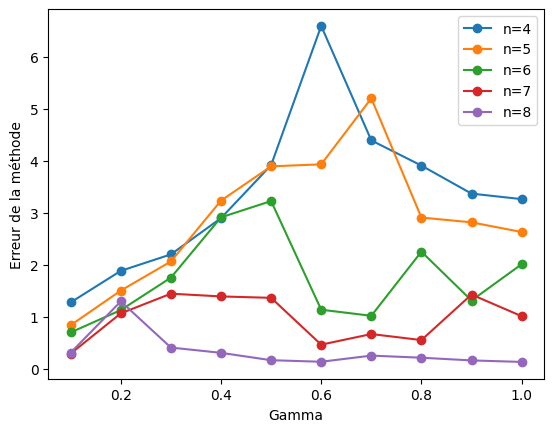

In [301]:
gammaValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
def greedy_errors_weak(n):
    greedy_errors_weak_gamma = [weakgreedy(F2, gamma, n, 80)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 4,9):
    greedy_errors_weak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

Evaluation sur le dataset trigonométrique aléatoir uniformément répartie.

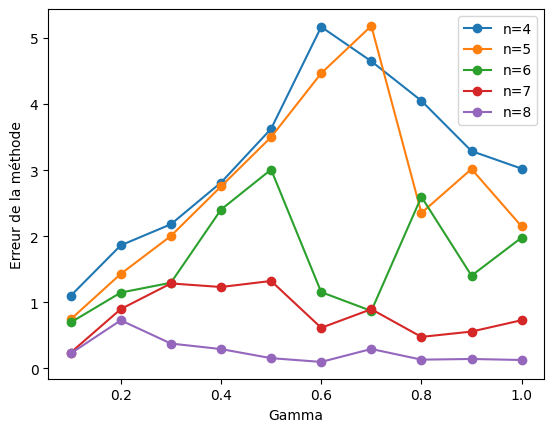

In [302]:
gammaValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
def greedy_errors_weak(n):
    greedy_errors_weak_gamma = [weakgreedy(F4, gamma, n, 80)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 4,9):
    greedy_errors_weak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

Evaluation sur le dataset uniforme polynomiale

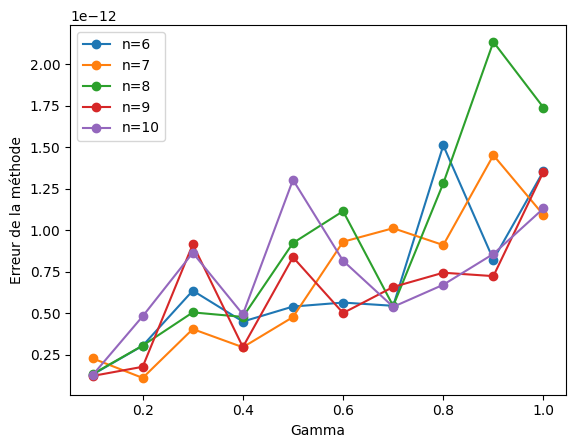

In [303]:
gammaValues = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
def greedy_errors_weak(n):
    greedy_errors_weak_gamma = [weakgreedy(F1, gamma, n, 80)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 6,11):
    greedy_errors_weak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

### Résultat weak weak greedy:

Arrêt anticipé à l'étape 0 veuillez relancer une autre méthode
Arrêt anticipé à l'étape 0 veuillez relancer une autre méthode
Arrêt anticipé à l'étape 0 veuillez relancer une autre méthode


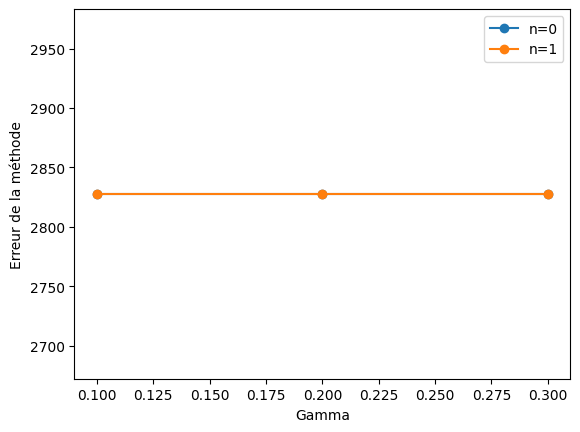

In [309]:
gammaValues = [0.1, 0.2, 0.3 ]
def greedy_errors_weakweak(n):
    greedy_errors_weak_gamma = [weakweakgreedy(F1, gamma, n)[1][-1] for gamma in gammaValues]
    plt.plot(gammaValues, greedy_errors_weak_gamma, 'o-', label=f'n={n}')

for i in range( 0,2):
    greedy_errors_weakweak(i)
plt.xlabel('Gamma')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

Les résultats ne sont pas concluant, la méthode weakweak est destiné à être un échec. On aurais pu s'en douter, on considère des espaces compact qui permettent une approximation strictement meilleure à chaque degré.

### Comparaison Strong et Weak

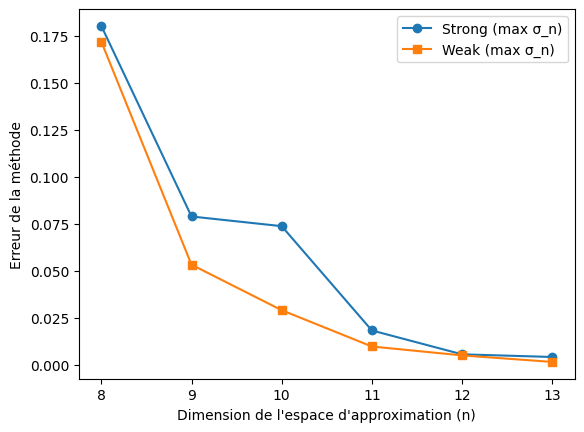

In [310]:
n_values = range(8, 14)

greedy_errors_strong = [stronggreedy(F4, n)[1][-1] for n in n_values]  
greedy_errors_weak = [weakgreedy(F4, 0.5, n, 100)[1][-1] for n in n_values]  

plt.plot(n_values, greedy_errors_strong, 'o-', label='Strong (max σ_n)')
plt.plot(n_values, greedy_errors_weak, 's-', label='Weak (max σ_n)')
plt.xlabel('Dimension de l\'espace d\'approximation (n)')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

On remarque que la méthode strong permet une erreur plus faible. C'est un résultat attendue, on considère l'argmax et plus un élément qui s'approche de l'argmax. On remarque que pour un espace très grand la méthode weak est légerement meilleure. C'est probablement dus à des erreurs de discrétisations qui se propagent et se cummulent. 

### Comparaison des résultats entre PCA Sklearn et PCA maison

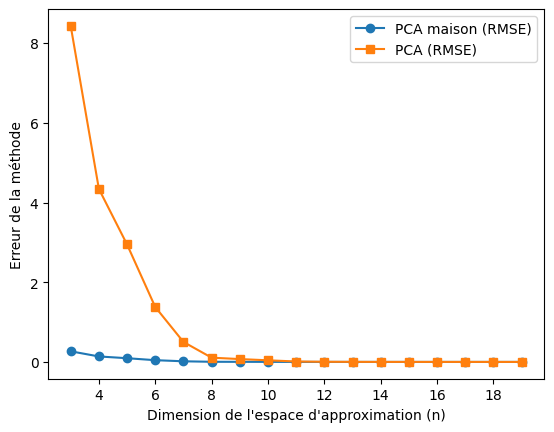

In [ ]:
n_values = range(3, 20)

pca_o_errors = [pca(F3, n)[2] for n in n_values] 
pca_errors = [pca_reduction(F3, n)[1] for n in n_values]  

plt.plot(n_values, pca_o_errors, 'o-', label='PCA maison (RMSE)')
plt.plot(n_values, pca_errors, 's-', label='PCA (RMSE)')
plt.xlabel('Dimension de l\'espace d\'approximation (n)')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

### Comparaison des résultats entre Strong et PCA

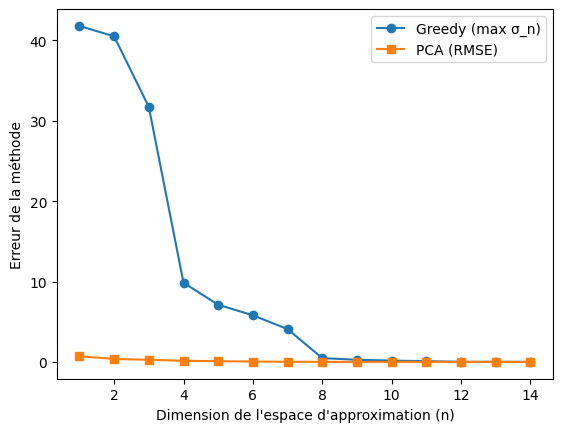

In [ ]:
n_values = range(1, 15)

greedy_errors_strong = [stronggreedy(F3, n)[1][-1] for n in n_values] 
pca_errors = [pca(F3, n)[2] for n in n_values]  

plt.plot(n_values, greedy_errors_strong, 'o-', label='Greedy (max σ_n)')
plt.plot(n_values, pca_errors, 's-', label='PCA (RMSE)')
plt.xlabel('Dimension de l\'espace d\'approximation (n)')
plt.ylabel('Erreur de la méthode')
plt.legend()
plt.show()

On observe que l'erreur des deux méthodes converge vers 0. Ce résultat est assurer par la compacité de notre ensemble d'approximation.

On note que l'on compare ici une erreur en norme L1 à une erreur en norme L2. On s'attend normalement l'erreur étant strictement inférieur à 1 à ce que la norme 2 soit inférieure.

### Comparaison temps de calcul entre les différents méthodes

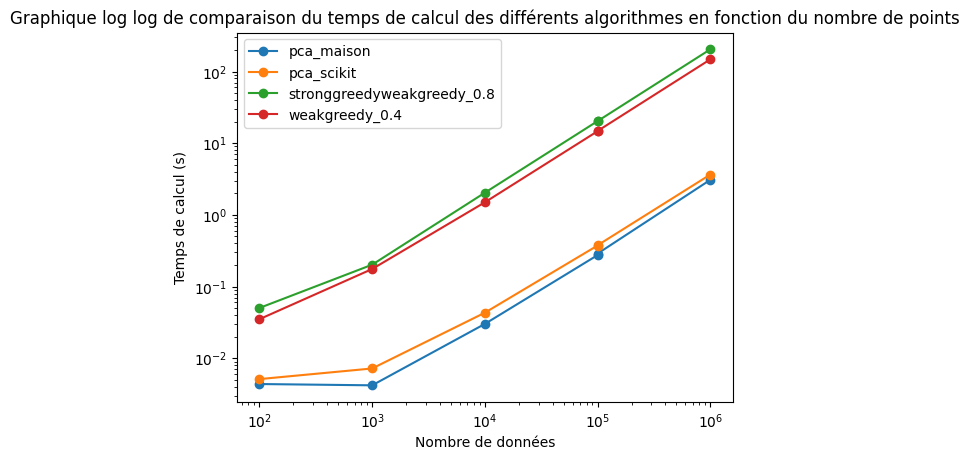

In [ ]:
n=7
samplesize=100
F_list = [F2,F3, F4,F4bis,F4ter,F4qua]
tailles = [len(F) for F in F_list]

algorithms = [pca,pca_reduction ,stronggreedy,weakgreedy,weakgreedy ]
labels = ['pca_maison', 'pca_scikit','stronggreedy' 'weakgreedy_0.8','weakgreedy_0.4']

times = {label: [] for label in labels}

for alg, label in zip(algorithms, labels):
    for F in F_list:
        if label=='weakgreedy_0.8':
            gam=0.8
            start = time.time()
            _ = alg(F,gam,n,samplesize)
            end = time.time()
            times[label].append(end - start)
        if label=='weakgreedy_0.4':
            gam=0.4
            start = time.time()
            _ = alg(F,gam,n,samplesize)
            end = time.time()
            times[label].append(end - start)
        else:
            start = time.time()
            _ = alg(F,n)
            end = time.time()
            times[label].append(end - start)

# Plotting
plt.figure()
for label in labels:
    plt.plot(tailles, times[label], marker='o', label=label)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Nombre de données')
plt.ylabel('Temps de calcul (s)')
plt.legend()
plt.title('Graphique log log de comparaison du temps de calcul des différents algorithmes en fonction du nombre de points')
plt.show()

## Conclusion


La PCA reste meilleure, le strong meilleure que le weak, mais pas de beaucoup et donc autant prendre le gain de temps.

A faire faire le rapport.